In [9]:
import shapefile
import netCDF4 as nc
import pyproj
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (15.,15)

In [2]:
# Filenames, directories and options
SOIL_DIR='/prj/GREENHOUSE/SOIL_PROPERTIES/datasets/Scotland_Soil_Data/'
shpvar='soil_250k'
shp_file=SOIL_DIR+shpvar+'/'+shpvar+'.shp'
if shpvar=='soiltexture':
    shp_file=SOIL_DIR+shpvar+'/'+shpvar+'_osgb.shp'
#prj_file=SOIL_DIR+shpvar+'/'+shpvar+'.prj'
print(shp_file)

LatLon_file='/users/eow/edwcom/CHESS/chess_landcover_2000.nc'

LUT_file=SOIL_DIR+'SSKIB_OCT13_orgcarbGapFilled.csv'

osgb36=pyproj.Proj('+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +datum=OSGB36 +units=m +no_defs' ) # UK Ordnance Survey, 1936 datum 

OUTFILE=SOIL_DIR+'Scot_Soil_Constituents_CHESSgrid.nc'


fill_value=-9999.

/prj/GREENHOUSE/SOIL_PROPERTIES/datasets/Scotland_Soil_Data/soil_250k/soil_250k.shp


In [3]:
#Read in LUT
LUT_lines=open(LUT_file).readlines()
LUT_lines=[line[:-1] for line in LUT_lines]
headers=LUT_lines.pop(0).split(',')
#print(headers)
sand_index=headers.index('SAND_MED')
silt_index=headers.index('SILT_MED')
clay_index=headers.index('CLAY_MED')
temp_LUT_Dict={hdr:[] for hdr in headers}
for line in LUT_lines:
    vals=line.split(',')
    # Unless there are values for sand, silt, clay, OC and ph, throw line away
    if (vals[sand_index]!='')&(vals[silt_index]!='')&(vals[clay_index]!=''):
        for hdr,val in zip(headers,vals):
            if val=='':
                val='-1'
            temp_LUT_Dict[hdr].append(val)

Req_Headers=['LAND_USE', 'SERIES_NAME', 'SERIES_CODE', \
             'HORZ_TOP', 'HORZ_BOTTOM', \
             'CA_MED', 'MG_MED','NA_MED','K_MED','H_MED',          \
             'PH_W_MED','CARBON_MED','NITROGEN_MED','TOTAL_P_MED', \
             'SAND_MED','SILT_MED','CLAY_MED', 'organic_matter_med' ]

LUT_Dict={hdr:temp_LUT_Dict[hdr] for hdr in Req_Headers}

#cult_flag=np.zeros(len(LUT_Dict['LAND_USE']))
#cult_flag[np.array(LUT_Dict['LAND_USE'])=='CULT']=1
#LUT_Dict['LAND_USE']=cult_flag

for hdr in Req_Headers[2:]:
    LUT_Dict[hdr]=[float(val) for val in LUT_Dict[hdr]]
for hdr in Req_Headers:
    LUT_Dict[hdr]=np.array(LUT_Dict[hdr])


# Sub missing median values for mean value
#MED_hdrs=['CA_MED', 'MG_MED','NA_MED','K_MED','H_MED',          \
#          'PH_W_MED','CARBON_MED','NITROGEN_MED','TOTAL_P_MED', \
#          'SAND_MED','SILT_MED','CLAY_MED', 'organic_matter_med' ]
#MEAN_hdrs=['CA_MEAN', 'MG_MEAN','NA_MEAN','K_MEAN','H_MEAN',          \
#          'PH_W_MEAN','CARBON_MEAN','NITROGEN_MEAN','TOTAL_P_MEAN', \
#          'SAND_MEAN','SILT_MEAN','CLAY_MEAN', 'organic_matter_mean' ]#
#
#for MEDhd,MEANhd in zip(MED_hdrs,MEAN_hdrs):
#    if any (LUT_Dict[MEDhd]==-1):
#        print(MEDhd)
#        LUT_Dict[MEDhd][LUT_Dict[MEDhd]==-1]=np.array(temp_LUT_Dict[MEANhd])[LUT_Dict[MEDhd]==-1]
#        print(np.where(LUT_Dict[MEDhd]==-1))

LUT_Dict['MEAN_DEPTH']=(LUT_Dict['HORZ_TOP']+LUT_Dict['HORZ_BOTTOM'])/200.



In [12]:
print(1.5031/0.0418)

35.959330143540676


(array([ 672.,  318.,  220.,  191.,  132.,   65.,   56.,   37.,   34.,
          12.,   14.,    9.,   14.,    3.,    1.,    3.,    3.,    3.,
           0.,    4.,    1.,    2.,    3.,    4.,    4.,    1.,    0.,
           1.,    2.,    0.,    4.,    2.,    0.,    0.,    1.,    0.,
           1.,    1.,    1.,    2.,    0.,    3.,    1.,    3.,    4.,
           1.,    5.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 47 Patch objects>)

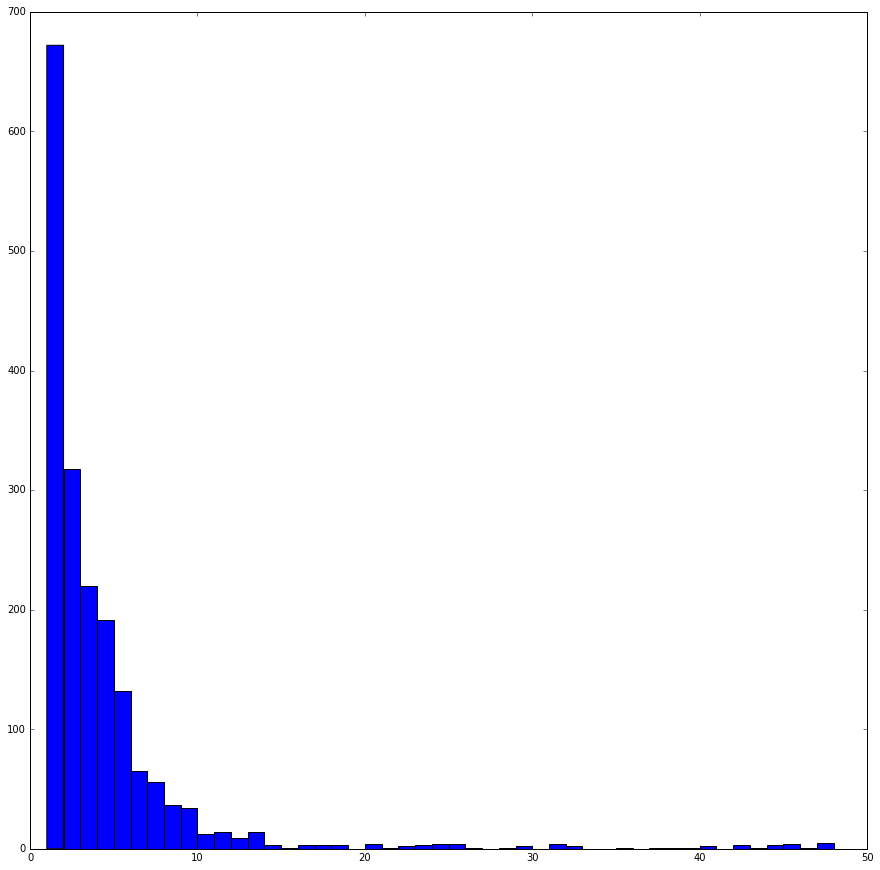

In [11]:
#for var in LUT_Dict:
    #print(var)
    
plt.hist(LUT_Dict['CARBON_MED'],bins=np.arange(1,49,1))

In [4]:
#read in latlon/xy data from chess_landcover
LLinf=nc.Dataset(LatLon_file,'r')
lats=LLinf.variables['lat'][:]
lons=LLinf.variables['lon'][:]
landcover=LLinf.variables['frac'][:]
x=LLinf.variables['x'][:]
y=LLinf.variables['y'][:]
#LLinf.close()
CHESS_maxLC=np.ma.masked_array(np.argmax(landcover,axis=0), \
                               mask=landcover.mask[0,:,:],  \
                               fill_value=fill_value )
CHESS_maxLC.data[CHESS_maxLC.mask==True]=fill_value
CHESS_cropFrac=landcover[4,:]


In [5]:
#CHESS_cropFrac.mask[j,i]

In [6]:
CH_soil_depths=np.array([0.1,0.35,1.0,3.0])
CH_mean_soil_depths=np.array([0.05,0.225,0.675,2.0])
nx=len(x)
ny=len(y)
nSD=len(CH_soil_depths)

Const_in_names=['CA_MED','MG_MED','NA_MED', 'K_MED', 'H_MED', \
                'PH_W_MED', 'CARBON_MED', 'NITROGEN_MED', 'TOTAL_P_MED',\
                'SAND_MED', 'SILT_MED', 'CLAY_MED', 'organic_matter_med']
Const_out_names=['calcium','magnesium','sodium','potassium','hydrogen', \
                 'ph','carbon','nitrogen','phospherous', \
                 'sand','silt','clay','org_matter'] #'sand_fine','sand_med','sand_coarse',

CHESS_SoilConst={ varname: np.zeros([nSD,ny,nx]) \
                    for varname in Const_out_names  }



In [7]:
SF=shapefile.Reader(shp_file)
field_names=[field[0] for field in SF.fields]
field_names.pop(0)
ShRcs=SF.shapeRecords()


In [8]:
ShRc=ShRcs[11746]
for fname,rec in zip(field_names,ShRc.record):
    print(fname,' - ',rec)
print(ShRc.shape.bbox)
print('______________')

objectid  -  10502
qmunit  -  259
assoc  -  FRASERBURGH
maplegend  -  Brown calcareous soils, calcareous regosols
mapsymb84  -  CALC
mapsymb13  -  CALC
compsoil84  -  Brown calcareous soils with calcareous regosols
compsoil  -  Brown calcareous soils with calcareous regosols
msg84_1  -  Calcareous soils
mssg84_1  -  Brown calcareous soils
series1  -  Fraserburgh
sercde1  -  23021
pcent1  -  50
rank_dom1  -  1
msg84cde1  -  2.2
mssg84cde1  -  2.2.1
msg13cde1  -  2.2
mssg13cde1  -  2.2.1
msg13_1  -  Calcareous soils
mssg13_1  -  Brown calcareous soils
msg84_2  -  Regosols
mssg84_2  -  Calcareous regosols
series2  -  FRASERBURGH(CALREG)
sercde2  -  23049
pcent2  -  50
rank_dom2  -  2
msg84cde2  -  1.2
mssg84cde2  -  1.2.1
msg13cde2  -  1.3
mssg13cde2  -  1.3.3
msg13_2  -  Regosols
mssg13_2  -  Calcareous regosols
msg84_3  -                                                                                                                                                                        

In [8]:
CHESS_SoilConst={ varname: np.zeros([nSD,ny,nx]) \
                    for varname in Const_out_names  }
TOTAL_FRACTION=np.zeros([ny,nx])
#ShRc_index=[]
#CHECK_index=[]
MAX_SERIES=8
for iShRc in range(len(ShRcs)):
    #print(iShRc)
    ShRc=ShRcs[iShRc]
    # Get Soil Series ID and percent lists for shape
    series_num=1
    Soil_Series_ID=[]
    Soil_Series_PC=[]
    SIDindex=field_names.index('sercde'+str(series_num))
    SPCindex=field_names.index('pcent'+str(series_num))
    temp_seriesID=ShRc.record[SIDindex]
    temp_seriesPC=ShRc.record[SPCindex]
    while (temp_seriesID[:1]!='\x00')&(series_num<MAX_SERIES):
        Soil_Series_ID.append(int(temp_seriesID))
        Soil_Series_PC.append(float(temp_seriesPC)/100.)
        series_num+=1
        SIDindex=field_names.index('sercde'+str(series_num))
        SPCindex=field_names.index('pcent'+str(series_num))
        temp_seriesID=ShRc.record[SIDindex]
        temp_seriesPC=ShRc.record[SPCindex]
    
    nSS=len(Soil_Series_ID)
    if nSS==0:
        continue
    
    # Loop around each soil series and sum weighted components for each Const field
    # Create profiles arrays for each output parameter for SEMI and CULT Land uses
    SEMI_profiles={ varname: np.zeros([nSD]) for varname in Const_out_names }
    CULT_profiles={ varname: np.zeros([nSD]) for varname in Const_out_names }
    PROFILE_PERCENT=0
    for iSS in range(nSS):
        full_LUT_index=np.where(LUT_Dict['SERIES_CODE']==Soil_Series_ID[iSS])[0]
        
        # Calculate Cultivated and Semi land-use constituent independently, if and where available
        # Semi first
        if 'SEMI'in LUT_Dict['LAND_USE'][full_LUT_index]:
            LUT_index = full_LUT_index[LUT_Dict['LAND_USE'][full_LUT_index]=='SEMI']
            # loop over output soil depths
            for iSD in range(nSD):
                # find closest input SD
                SD_index=np.argmin(np.abs( LUT_Dict['MEAN_DEPTH'][LUT_index]\
                                           -CH_mean_soil_depths[iSD]) )
                # INDEX of the closest soil depth for the series
                INDEX=LUT_index[SD_index]
                # Loop over output parameters
                for inname,outname in zip(Const_in_names,Const_out_names):
                    #for each param, at each soil depth, sum the weighted components
                    SEMI_profiles[outname][iSD]+=(LUT_Dict[inname][INDEX]*Soil_Series_PC[iSS])
            COPY_FROM_CULT=0
        else:
            COPY_FROM_CULT=1
    
        # Next 'CULT
        if 'CULT'in LUT_Dict['LAND_USE'][full_LUT_index]:
            LUT_index = full_LUT_index[LUT_Dict['LAND_USE'][full_LUT_index]=='CULT']
            # loop over output soil depths
            for iSD in range(nSD):
                # find closest input SD
                SD_index=np.argmin(np.abs( LUT_Dict['MEAN_DEPTH'][LUT_index]\
                                           -CH_mean_soil_depths[iSD]) )
                # INDEX of the closest soil depth for the series
                INDEX=LUT_index[SD_index]
                # Loop over output parameters
                for inname,outname in zip(Const_in_names,Const_out_names):
                    #for each param, at each soil depth, sum the weighted components
                    CULT_profiles[outname][iSD] += (LUT_Dict[inname][INDEX]*Soil_Series_PC[iSS])
            COPY_FROM_SEMI=0
        else:
            COPY_FROM_SEMI=1
    
        # Copy Profile Dictionaries from other land-use type where possible Where neccessary
        if (COPY_FROM_CULT==1)&(COPY_FROM_SEMI==0):
            if 'CULT'in LUT_Dict['LAND_USE'][full_LUT_index]:
                LUT_index = full_LUT_index[LUT_Dict['LAND_USE'][full_LUT_index]=='CULT']
                for iSD in range(nSD):
                    SD_index=np.argmin(np.abs( LUT_Dict['MEAN_DEPTH'][LUT_index] \
                                              -CH_mean_soil_depths[iSD]) )
                    INDEX=LUT_index[SD_index]
                    for inname,outname in zip(Const_in_names,Const_out_names):
                        SEMI_profiles[outname][iSD] += (LUT_Dict[inname][INDEX]*Soil_Series_PC[iSS])
                COPY_FROM_CULT=0
            else:
                COPY_FROM_CULT=1
        elif (COPY_FROM_CULT==0)&(COPY_FROM_SEMI==1):
            if 'SEMI'in LUT_Dict['LAND_USE'][full_LUT_index]:
                LUT_index = full_LUT_index[LUT_Dict['LAND_USE'][full_LUT_index]=='SEMI']
                for iSD in range(nSD):
                    SD_index=np.argmin(np.abs( LUT_Dict['MEAN_DEPTH'][LUT_index] \
                                              -CH_mean_soil_depths[iSD]) )
                    INDEX=LUT_index[SD_index]
                    for inname,outname in zip(Const_in_names,Const_out_names):
                        CULT_profiles[outname][iSD] += (LUT_Dict[inname][INDEX]*Soil_Series_PC[iSS])
                COPY_FROM_CULT=0
            else:
                COPY_FROM_CULT=1
            
        if (COPY_FROM_CULT==0)|(COPY_FROM_SEMI==0):
            PROFILE_PERCENT+=Soil_Series_PC[iSS]
    
    # if Profile Percent = 0 there is no relevent information for the shape so move on
    # This will be closest neighbour gap filled later
    if PROFILE_PERCENT==0:
        continue
    
    # Now Normalise the Profiles based on the percentage complete
    for outname in Const_out_names:
        CULT_profiles[outname]=CULT_profiles[outname]/PROFILE_PERCENT
        SEMI_profiles[outname]=SEMI_profiles[outname]/PROFILE_PERCENT
    
    # Calculate the fraction of each overlapping CHESS chess grid square
    limits=[int(bbox/1e3) for bbox in ShRc.shape.bbox]
    x_limits=[limits[0],limits[2]]
    y_limits=[limits[1],limits[3]]
    if min(y_limits)>ny:
        continue
    if min(x_limits)>nx:
        continue
    INpoly=Polygon(ShRc.shape.points)
    INpoly=INpoly.buffer(0)
    
    for i in range(x_limits[0],x_limits[1]+1):
        for j in range(y_limits[0],y_limits[1]+1):
            if not CHESS_cropFrac.mask[j,i]:
                # CHESS polygons are 1km squares with a LL corner = j,i
                OUTpoly= Polygon( ( (i*1e3,j*1e3),\
                                    (i*1e3,j*1e3+1e3),\
                                    (i*1e3+1e3,j*1e3+1e3),\
                                    (i*1e3+1e3,j*1e3),\
                                    (i*1e3,j*1e3),\
                                )  )
                # Check for intersecting polygons
                if OUTpoly.intersects(INpoly):
                    # Get aarea of overlap
                    OVERLAP=OUTpoly.intersection(INpoly)
                    FRACTION=OVERLAP.area/1e6
                    TOTAL_FRACTION[j,i]+=FRACTION
                    for inname,outname in zip(Const_in_names,Const_out_names):
                        #for each param, at each soil depth, sum the weighted components
                        CHESS_SoilConst[outname][:,j,i]+= \
                            ( CULT_profiles[outname] * CHESS_cropFrac[j,i] + \
                              SEMI_profiles[outname] * (1-CHESS_cropFrac[j,i]) ) * \
                            FRACTION
    

0 170.070558304 0.0 5.83369766024
1 170.070558304 0.0 5.83369766024
2 170.070558304 0.0 5.83369766024
3 170.070558304 0.0 5.83369766024


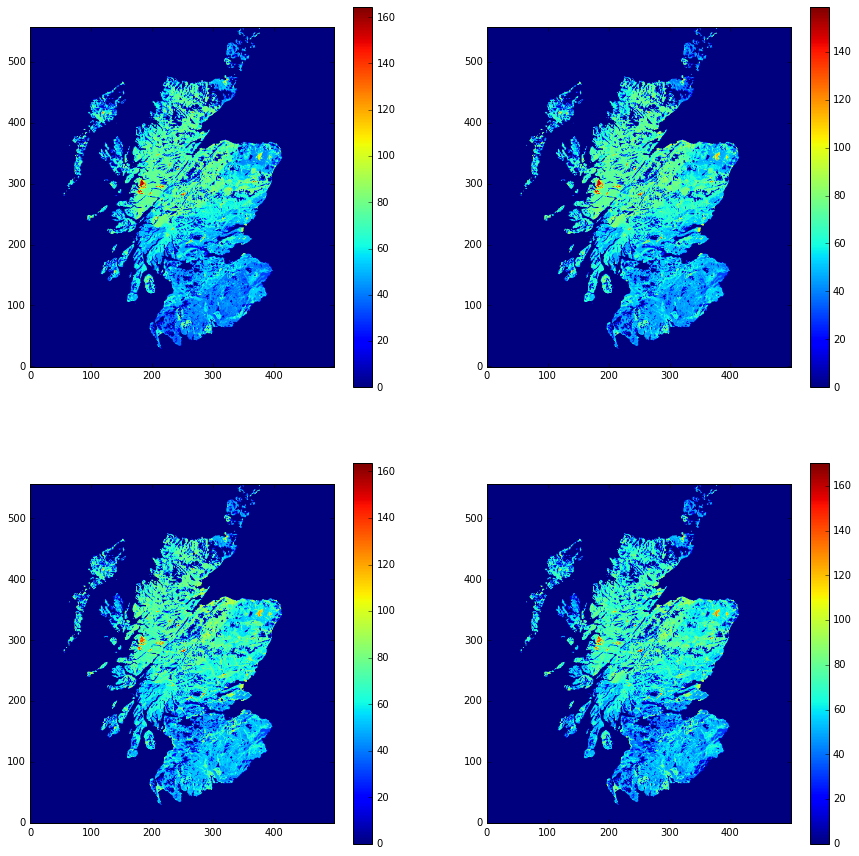

In [10]:
plotdata=(CHESS_SoilConst['sand'])
plt.figure(figsize=(15,15))
for iSD in range(4):
    print(iSD,plotdata.max(),plotdata.min(),plotdata.mean())
    plt.subplot(2,2,iSD+1)
    plt.imshow(plotdata[iSD,500:,:500],origin='bottom')#,vmax=1.1,vmin=0.9)
    plt.colorbar()
    

In [ ]:
#SAVE_CHECK_index=CHECK_index.copy()
#print(len(CHECK_index))
#print(len(SAVE_CHECK_index))
#shindex_outf=open(SOIL_DIR+'shape_index.dat','w')
#shindex_outf.write(CHECK_index)
#shindex_outf.close()

In [ ]:
#import copy
#CHESS_SoilConst_BU=copy.deepcopy(CHESS_SoilConst)
#TOTAL_FRACTION_BU=copy.deepcopy(TOTAL_FRACTION)

In [ ]:
# Filter any locations with a fraction cover less than 20%
ZEROindex=np.where(TOTAL_FRACTION<0.2)
TOTAL_FRACTION[ZEROindex]=0

# Normalise to a TOTAL_Fraction of 1
TFindex=np.where(TOTAL_FRACTION>=0.2)
for outname in Const_out_names:    
    CHESS_SoilConst[outname][:,ZEROindex[0],ZEROindex[1]]=0.
    CHESS_SoilConst[outname][:,TFindex[0],TFindex[1]]/= \
            TOTAL_FRACTION[TFindex]
    CHESS_SoilConst[outname]=np.ma.masked_equal(CHESS_SoilConst[outname],0.)
    CHESS_SoilConst[outname].data[CHESS_SoilConst[outname].mask==True]=fill_value
    CHESS_SoilConst[outname].fill_value=fill_value

In [ ]:
MAXdex=CHESS_SoilConst['sand'][0,:].argmax()
print(MAXdex)
print(CHESS_SoilConst['sand'][0,:].max())
print(CHESS_SoilConst['sand'][0,:].flat[MAXdex])
print(TOTAL_FRACTION.flat[MAXdex])
print(CHESS_cropFrac.flat[MAXdex])
print(np.where(TOTAL_FRACTION==TOTAL_FRACTION.flat[MAXdex]))

In [ ]:
# Normalise sand/silt/clay fractions
TOTAL_SSC=(CHESS_SoilConst['sand']+CHESS_SoilConst['silt']+CHESS_SoilConst['clay'])/100.
for soil_comp in ['sand','silt','clay']:
    CHESS_SoilConst[soil_comp]/=TOTAL_SSC


In [ ]:
for var in CHESS_SoilConst:
    print(var)

In [ ]:

###############################################################
# Output data to netCDF file:
###############################
outf=nc.Dataset(OUTFILE,'w')

# Create Dimensions
outf.createDimension('x',nx)
outf.createDimension('y',ny)
outf.createDimension('z',nSD)

# write out dimension variables
for var in ['x','y']:
    outvar=outf.createVariable(var,'float32',(var))
    for att in LLinf.variables[var].ncattrs():
        outvar.setncattr(str(att),LLinf.variables[var].getncattr(str(att)))
    outvar[:]=LLinf.variables[var][:]

outvar=outf.createVariable('z','float32',('z'))
outvar.units='m'
outvar.long_name='lower soil depth'
outvar[:]=CH_soil_depths

# Loop around soil parameters and 
for var in CHESS_SoilConst:
    outvar=outf.createVariable(var,'float32',('z','y','x'),fill_value=fill_value)
    if var=='ph':
        outvar.units='pH'
    else:
        outvar.units='percent'
    outvar[:]=CHESS_SoilConst[var]
    
outf.close()


In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(TOTAL_FRACTION[TOTAL_FRACTION>0],range=(0,2))
plt.subplot(1,2,2)
plt.imshow(TOTAL_FRACTION[500:,:500],origin='bottom')
plt.colorbar()
print(np.max(TOTAL_FRACTION))
print(np.min(TOTAL_FRACTION))
print(np.mean(TOTAL_FRACTION))

In [ ]:
plotdata=(CHESS_SoilConst['sand'])#+CHESS_SoilConst['silt']+CHESS_SoilConst['clay'])/100.
plt.figure(figsize=(15,15))
for iSD in range(4):
    print(iSD,plotdata.max(),plotdata.min(),plotdata.mean())
    plt.subplot(2,2,iSD+1)
    plt.imshow(plotdata[iSD,500:,:500],origin='bottom')#,vmax=1.1,vmin=0.9)
    plt.colorbar()
    

In [ ]:
plt.figure(figsize=(20,8))

plotdata=CHESS_SoilConst['sand']
plt.subplot(1,3,1)
plt.imshow(plotdata[0,500:,:500],origin='bottom',vmax=150,vmin=0)
plt.colorbar()

plotdata=CHESS_SoilConst['sand']-CHESS_SoilConst_BU['sand']
plt.subplot(1,3,2)
plt.imshow(plotdata[0,500:,:500],origin='bottom',cmap='RdBu')
plt.colorbar()

plotdata=CHESS_SoilConst_BU['sand']
plt.subplot(1,3,3)
plt.imshow(plotdata[0,500:,:500],origin='bottom',vmax=150,vmin=0)
plt.colorbar()


In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(TOTAL_FRACTION[500:,:500],origin='bottom',vmax=1.1)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow((1-CHESS_cropFrac[500:,:500]),origin='bottom')
plt.colorbar()

In [ ]:
#from shapely.geometry import Polygon
#print(nx,ny)
print(landcover.shape)
TOTAL_FRACTION=np.zeros([ny,nx])

In [ ]:
#j,i=842,288
j,i=594,258
print(TOTAL_FRACTION[j,i])
outname='sand'
#print(CHESS_SoilConst['sand'][:,j,i])
#print(CHESS_SoilConst['silt'][:,j,i])
#print(CHESS_SoilConst['clay'][:,j,i])

print(CHESS_SoilConst[outname][:,j,i])
print(CULT_profiles[outname])
print(CHESS_cropFrac[j,i])
print(SEMI_profiles[outname])


In [ ]:
print(x_limits[0],x_limits[1])
print(y_limits[0],y_limits[1])
print(CHESS_SoilConst['sand'].shape)
print(CHESS_SoilConst['sand'][:,y_limits[0]:y_limits[1]+1,x_limits[0]:x_limits[1]+1])

In [ ]:
plt.figure(figsize=(15,15))
for iShRc in ShRc_index:
    ShRc=ShRcs[iShRc]
    INpoly=Polygon(ShRc.shape.points)
    x,y=INpoly.exterior.xy
    plt.plot(x,y)

    

In [ ]:
MASK_4level=np.array( [TOTAL_FRACTION==0 for i in range(nSD)])
print(MASK_4level.shape)

In [ ]:
# Fill missing values laterally:
# Sum soil components, this should sum to 100%
total_soil=CHESS_SoilConst['clay']+CHESS_SoilConst['silt']+CHESS_SoilConst['sand']
# loop over soil depths
for iSD in range(nSD): 
    badex=np.where(total_soil.data[iSD,:]==0.0)
    goodex=np.where(total_soil.data[iSD,:]>99.0)
    goodex = [ good.astype(float) for good in goodex ]
    for iBAD in zip(badex[0],badex[1]):
        closest_good=np.argmin( np.abs( (goodex[0]-iBAD[0]) + (goodex[1]-iBAD[1]) ) )
        closest_good=int(closest_good)
        #print(iBAD,(goodex[0][closest_good],goodex[1][closest_good]))
    
    goodex = [ good.astype(int) for good in goodex ]
    for name in ['sand','silt','clay']:
        CHESS_SoilConst[name][iSD,badex[0],badex[1]] = \
            CHESS_SoilConst[name][iSD,goodex[0][closest_good],goodex[1][closest_good]]
        
total_soil=CHESS_SoilConst['clay']+CHESS_SoilConst['silt']+CHESS_SoilConst['sand']
for name in ['sand','silt','clay']:
    CHESS_SoilConst[name] = CHESS_SoilConst[name] * 100. / total_soil
    